In [1]:
# !pip install --upgrade scipy

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix
import scipy
from scipy import io

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
batch_size = 32
output_nodes = 10
learning_rate = 0.001

In [5]:
# train_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/train"
# val_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/dev"
# test_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/test"
# import os
# import random
# import numpy as np
# import scipy.io
# from torch.utils.data import Dataset
# import torch

# class PtDataset(Dataset):
#     def __init__(self, directory, max_len=10):
#         """
#         Custom dataset for loading .mat files from a directory structure.
#         Args:
#             directory (str): The path to the root data directory.
#             max_len (int): The maximum sequence length for padding/truncating.
#         """
#         self.directory = directory
#         self.classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
#         self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
#         self.files = []
#         self.max_len = max_len
#         for c in self.classes:
#             c_dir = os.path.join(directory, c)
#             c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir) if f.endswith('.mat')]
#             self.files.extend(c_files)
#         random.shuffle(self.files)
        
#     def __len__(self):
#         return len(self.files)
    
#     def __getitem__(self, idx):
#         """
#         Load a .mat file, process it to the required shape, and return it with the label.
#         """
#         filepath, label = self.files[idx]
#         try:
#             mat_vals = scipy.io.loadmat(filepath)
#             data = mat_vals['final']  # Assuming 'final' is the key for data
#             data = data.T  # Transpose to (time, features)
#             feature_dim = data.shape[1]

#             # Ensure data is exactly (max_len, feature_dim)
#             if data.shape[0] < self.max_len:
#                 pad_width = self.max_len - data.shape[0]
#                 data = np.pad(data, pad_width=((0, pad_width), (0, 0)), mode='constant')
#             else:
#                 data = data[:self.max_len, :]

#             # Flatten data to fit conv1d input (batch_size, in_channels, length)
#             data = data.reshape(1, -1)  # Reshape to (1, max_len * feature_dim)
#             data = torch.from_numpy(data).double()  # Convert to tensor
#         except Exception as e:
#             print(f"Error loading file {filepath}: {str(e)}")
#             return self.__getitem__((idx + 1) % len(self.files))  # Retry with a different sample

#         return data, label


# train_dataset = PtDataset(train_data_path)
# val_dataset = PtDataset(val_data_path)
# test_dataset = PtDataset(test_data_path)
# class PtDataLoader(DataLoader):
#     def __init__(self, directory, batch_size, shuffle=True):
#         dataset = PtDataset(directory)
#         super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

# train_dataloader = PtDataLoader(directory=train_data_path, batch_size=batch_size)
# val_dataloader = PtDataLoader(directory=val_data_path, batch_size=batch_size)
# test_dataloader = PtDataLoader(directory=test_data_path, batch_size=batch_size)
# train_count = len(train_dataset) 
# val_count = len(val_dataset)
# test_count = len(test_dataset)
# print(train_count)
# print(val_count)
# print(test_count)

In [6]:
import os
import random
import numpy as np
import scipy.io
from torch.utils.data import Dataset, DataLoader
import torch

class PtDataset(Dataset):
    def __init__(self, directories, max_len=10):
        """
        Args:
            directories (tuple or str): Either 
                - a string (for single feature like before), or
                - a tuple (mfcc_dir, lfcc_dir) for two features.
        """
        if isinstance(directories, str):
            raise ValueError("Now you must pass both MFCC and LFCC directories as a tuple.")

        self.dir_mfcc, self.dir_lfcc = directories
        self.max_len = max_len

        # get classes from mfcc directory (assume same for lfcc)
        self.classes = sorted(entry.name for entry in os.scandir(self.dir_mfcc) if entry.is_dir())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.files = []
        for c in self.classes:
            mfcc_c_dir = os.path.join(self.dir_mfcc, c)
            lfcc_c_dir = os.path.join(self.dir_lfcc, c)

            mfcc_files = [f for f in os.listdir(mfcc_c_dir) if f.endswith('.mat')]
            for f in mfcc_files:
                mfcc_fp = os.path.join(mfcc_c_dir, f)
                lfcc_fp = os.path.join(lfcc_c_dir, f)  # assumes same filenames
                self.files.append(((mfcc_fp, lfcc_fp), self.class_to_idx[c]))

        random.shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def pad_or_trim(self, data, max_len):
        if data.shape[0] < max_len:
            pad_width = max_len - data.shape[0]
            data = np.pad(data, pad_width=((0, pad_width), (0, 0)), mode='constant')
        else:
            data = data[:max_len, :]
        return data

    def __getitem__(self, idx):
        (mfcc_fp, lfcc_fp), label = self.files[idx]
        try:
            mfcc = scipy.io.loadmat(mfcc_fp)['final'].T  # (time, 20)
            lfcc = scipy.io.loadmat(lfcc_fp)['final'].T  # (time, 24)

            mfcc = self.pad_or_trim(mfcc, self.max_len)
            lfcc = self.pad_or_trim(lfcc, self.max_len)

            data = np.concatenate([mfcc, lfcc], axis=1)  # (10, 44)
            data = data[:, :40]                          # ensure 40 dims
            data = data.reshape(1, -1)                   # (1, 400)

            data = torch.from_numpy(data).double()

        except Exception as e:
            print(f"Error loading file {mfcc_fp} or {lfcc_fp}: {str(e)}")
            return self.__getitem__((idx + 1) % len(self.files))

        return data, label

# Train
train_data_path = (
    r"/kaggle/input/mfcc-new/mfcc/train",
    r"/kaggle/input/mgdcc-feature/MGDCC/train"
)

# Validation
val_data_path = (
    r"/kaggle/input/mfcc-new/mfcc/dev",
    r"/kaggle/input/mgdcc-feature/MGDCC/dev"
)

# Test
test_data_path = (
    r"/kaggle/input/mfcc-new/mfcc/test",
    r"/kaggle/input/mgdcc-feature/MGDCC/test"
)

# DataLoaders
train_dataset = PtDataset(train_data_path)
val_dataset   = PtDataset(val_data_path)
test_dataset  = PtDataset(test_data_path)

class PtDataLoader(DataLoader):
    def __init__(self, directory, batch_size, shuffle=True):
        dataset = PtDataset(directory)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = PtDataLoader(directory=train_data_path, batch_size=batch_size)
val_dataloader   = PtDataLoader(directory=val_data_path, batch_size=batch_size)
test_dataloader  = PtDataLoader(directory=test_data_path, batch_size=batch_size)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
train_count = len(train_dataset) 
val_count = len(val_dataset)
test_count = len(test_dataset)

111633
37152
37971


In [7]:
# train_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/train"
# val_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/dev"
# test_data_path = r"/kaggle/input/mgdcc-feature/MGDCC/test"

In [8]:
# Pick one sample from training dataset
sample_data, sample_label = train_dataset[0]

print("Sample feature shape:", sample_data.shape)   # should be (1, 400)
print("Sample label:", sample_label)

# If you want to see the first 10x40 stacked feature (before flatten):
(mfcc_fp, lfcc_fp), _ = train_dataset.files[0]
mfcc = scipy.io.loadmat(mfcc_fp)['final'].T
lfcc = scipy.io.loadmat(lfcc_fp)['final'].T

print("MFCC raw shape:", mfcc.shape)  # (time, 20)
print("LFCC raw shape:", lfcc.shape)  # (time, 24)


Sample feature shape: torch.Size([1, 400])
Sample label: 1
MFCC raw shape: (8, 20)
LFCC raw shape: (8, 20)


In [9]:
# import os
# import random
# import numpy as np
# import scipy.io
# from torch.utils.data import Dataset
# import torch

# class PtDataset(Dataset):
#     def __init__(self, directory, max_len=10):
#         """
#         Custom dataset for loading .mat files from a directory structure.
#         Args:
#             directory (str): The path to the root data directory.
#             max_len (int): The maximum sequence length for padding/truncating.
#         """
#         self.directory = directory
#         self.classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
#         self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
#         self.files = []
#         self.max_len = max_len
#         for c in self.classes:
#             c_dir = os.path.join(directory, c)
#             c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir) if f.endswith('.mat')]
#             self.files.extend(c_files)
#         random.shuffle(self.files)
        
#     def __len__(self):
#         return len(self.files)
    
#     def __getitem__(self, idx):
#         """
#         Load a .mat file, process it to the required shape, and return it with the label.
#         """
#         filepath, label = self.files[idx]
#         try:
#             mat_vals = scipy.io.loadmat(filepath)
#             data = mat_vals['final']  # Assuming 'final' is the key for data
#             data = data.T  # Transpose to (time, features)
#             feature_dim = data.shape[1]

#             # Ensure data is exactly (max_len, feature_dim)
#             if data.shape[0] < self.max_len:
#                 pad_width = self.max_len - data.shape[0]
#                 data = np.pad(data, pad_width=((0, pad_width), (0, 0)), mode='constant')
#             else:
#                 data = data[:self.max_len, :]

#             # Flatten data to fit conv1d input (batch_size, in_channels, length)
#             data = data.reshape(1, -1)  # Reshape to (1, max_len * feature_dim)
#             data = torch.from_numpy(data).double()  # Convert to tensor
#         except Exception as e:
#             print(f"Error loading file {filepath}: {str(e)}")
#             return self.__getitem__((idx + 1) % len(self.files))  # Retry with a different sample

#         return data, label


In [10]:

# train_dataset = PtDataset(train_data_path)
# val_dataset = PtDataset(val_data_path)
# test_dataset = PtDataset(test_data_path)

In [11]:
# class PtDataLoader(DataLoader):
#     def __init__(self, directory, batch_size, shuffle=True):
#         dataset = PtDataset(directory)
#         super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

In [12]:
# train_dataloader = PtDataLoader(directory=train_data_path, batch_size=batch_size)
# val_dataloader = PtDataLoader(directory=val_data_path, batch_size=batch_size)
# test_dataloader = PtDataLoader(directory=test_data_path, batch_size=batch_size)

In [13]:
# train_count = len(train_dataset) 
# val_count = len(val_dataset)
# test_count = len(test_dataset)

In [14]:
# print(train_count)
# print(val_count)
# print(test_count)

In [15]:
drop_amount = 0.255

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.nn.parameter import Parameter
from torch.utils import data

class Res2NetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale=4, kernel_size=3, stride=1, padding=1):
        super(Res2NetBlock, self).__init__()
        assert out_channels % scale == 0, "Output channels must be divisible by scale"
        self.scale = scale
        self.split_channels = out_channels // scale

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.convs = nn.ModuleList([
            nn.Conv1d(self.split_channels, self.split_channels, kernel_size, stride=stride, padding=padding, bias=False)
            for _ in range(scale - 1)
        ])

        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        splits = torch.chunk(out, self.scale, dim=1)
        out = splits[0]
        result = [out]  # Collect outputs here to avoid in-place addition
        for i, conv in enumerate(self.convs):
            result.append(conv(splits[i + 1]))
        out = torch.cat(result, dim=1)  # Concatenate all parts

        out = self.conv3(out)
        out = self.bn2(out)
        return self.relu(out)


class AMSoftmaxLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.4):
        super(AMSoftmaxLoss, self).__init__()
        self.s = s
        self.m = m
        self.weight = Parameter(torch.DoubleTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, labels):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        logits = one_hot * phi + (1.0 - one_hot) * cosine
        logits *= self.s
        return logits


class AASIST2(nn.Module):
    def __init__(self, d_args):
        super(AASIST2, self).__init__()
        self.res2net_block1 = Res2NetBlock(d_args['in_channels'], d_args['filts'][0], scale=4)
        self.res2net_block2 = Res2NetBlock(d_args['filts'][0], d_args['filts'][1], scale=4)
        self.res2net_block3 = Res2NetBlock(d_args['filts'][1], d_args['filts'][2], scale=4)

        self.gru = nn.GRU(input_size=d_args['filts'][2],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1 = nn.Linear(d_args['gru_node'], d_args['nb_fc_node'])  # Input size must match GRU hidden size
        self.fc2 = nn.Linear(d_args['nb_fc_node'], d_args['nb_classes'])  # Matches number of classes

        self.am_softmax = AMSoftmaxLoss(d_args['nb_fc_node'], d_args['nb_classes'])  # Use fc1 output size

    def forward(self, x, labels=None, is_test=False):
        x = self.res2net_block1(x)
        x = self.res2net_block2(x)
        x = self.res2net_block3(x)

        x = x.permute(0, 2, 1)  # Permute for GRU input [batch, sequence, feature]
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Take last time step output

        x = self.fc1(x)
        logits = self.fc2(x)

        if labels is not None:  # Compute AMSoftmax only if labels are provided
            return self.am_softmax(x, labels)
        else:  # Return logits for testing/inference
            return F.softmax(logits, dim=1)

d_args = {
    'in_channels': 1,
    'filts': [64, 128, 256],
    'gru_node': 128,
    'nb_gru_layer': 2,
    'nb_fc_node': 64,
    'nb_classes': 2
}
model = AASIST2(d_args)


In [16]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F

In [17]:
# Define the parameters
# input_size = 20
# hidden_size = 256
# num_layers = 2
# num_classes = 8

# model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
model.to(device, dtype=torch.double)

AASIST2(
  (res2net_block1): Res2NetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (relu): ReLU(inplace=True)
  )
  (res2net_block2): Res2NetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=Fal

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
print(model)

AASIST2(
  (res2net_block1): Res2NetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
    (relu): ReLU(inplace=True)
  )
  (res2net_block2): Res2NetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convs): ModuleList(
      (0-2): 3 x Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=Fal

In [21]:
#Model training and testing 
n_total_steps = len(train_dataloader) # n_total_steps * batch size will give total number of training files (consider that last batch may not be fully filled)
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
max_acc=0
num_epochs = 35
pred_labels =[]
act_labels = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from tqdm import tqdm

# Model training and testing 
n_total_steps = len(train_dataloader) 
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
max_acc = 0
num_epochs = 35
pred_labels = []
act_labels = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    # ✅ tqdm for training loop
    train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for batch_idx, (images, labels) in enumerate(train_bar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int((prediction == labels).sum().item())

        # Update tqdm bar
        train_bar.set_postfix({
            "loss": f"{loss.item():.4f}"
        })

    train_accuracy /= train_count
    train_loss /= train_count
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_accuracy = 0.0
    pred = []
    lab = []

    # ✅ tqdm for validation loop
    val_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int((prediction == labels).sum().item())
            pred.extend(prediction.cpu().tolist())
            lab.extend(labels.cpu().tolist())

    val_accuracy /= val_count
    val_accuracy_list.append(val_accuracy)

    if max_acc < val_accuracy:
        max_acc = val_accuracy
        pred_labels = pred
        actual_labels = lab
        torch.save(model, "best_accuracy_model_BiLSTM.pth")

    # Print epoch summary
    print(f"Epoch: {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

print("Max Accuracy:", max_acc)



Epoch: 1/35, Train Loss: 0.6331, Train Accuracy: 0.6098, Val Accuracy: 0.7894


Epoch: 2/35, Train Loss: 0.4630, Train Accuracy: 0.8440, Val Accuracy: 0.8571


Epoch: 3/35, Train Loss: 0.4199, Train Accuracy: 0.8883, Val Accuracy: 0.8830


Epoch: 4/35, Train Loss: 0.4016, Train Accuracy: 0.9072, Val Accuracy: 0.8744


Epoch: 5/35, Train Loss: 0.3920, Train Accuracy: 0.9178, Val Accuracy: 0.8702


Epoch: 6/35, Train Loss: 0.3846, Train Accuracy: 0.9260, Val Accuracy: 0.8733


Epoch: 7/35, Train Loss: 0.3737, Train Accuracy: 0.9369, Val Accuracy: 0.8957


Epoch: 8/35, Train Loss: 0.3684, Train Accuracy: 0.9425, Val Accuracy: 0.9201


Epoch: 9/35, Train Loss: 0.3648, Train Accuracy: 0.9464, Val Accuracy: 0.9155


Epoch: 10/35, Train Loss: 0.3643, Train Accuracy: 0.9469, Val Accuracy: 0.9164


Epoch: 11/35, Train Loss: 0.3599, Train Accuracy: 0.9513, Val Accuracy: 0.9216


Epoch: 12/35, Train Loss: 0.3583, Train Accuracy: 0.9532, Val Accuracy: 0.9184


Epoch: 13/35, Train Loss: 0.3568, Train Accuracy: 0.9547, Val Accuracy: 0.9061


Epoch: 14/35, Train Loss: 0.3558, Train Accuracy: 0.9557, Val Accuracy: 0.9188


Epoch: 15/35, Train Loss: 0.3558, Train Accuracy: 0.9558, Val Accuracy: 0.9230


Epoch: 16/35, Train Loss: 0.3536, Train Accuracy: 0.9581, Val Accuracy: 0.9202


Epoch: 17/35, Train Loss: 0.3537, Train Accuracy: 0.9579, Val Accuracy: 0.9199


Epoch: 18/35, Train Loss: 0.3517, Train Accuracy: 0.9601, Val Accuracy: 0.9225


Epoch: 19/35, Train Loss: 0.3540, Train Accuracy: 0.9577, Val Accuracy: 0.9310


Epoch: 20/35, Train Loss: 0.3510, Train Accuracy: 0.9607, Val Accuracy: 0.9269


Epoch: 21/35, Train Loss: 0.3522, Train Accuracy: 0.9595, Val Accuracy: 0.9247


Epoch: 22/35, Train Loss: 0.3518, Train Accuracy: 0.9597, Val Accuracy: 0.9170


Epoch: 23/35, Train Loss: 0.3524, Train Accuracy: 0.9594, Val Accuracy: 0.9266


Epoch: 24/35, Train Loss: 0.3516, Train Accuracy: 0.9602, Val Accuracy: 0.9120


Epoch: 25/35, Train Loss: 0.3516, Train Accuracy: 0.9604, Val Accuracy: 0.9223


Epoch: 26/35, Train Loss: 0.3520, Train Accuracy: 0.9598, Val Accuracy: 0.9222


Epoch: 27/35, Train Loss: 0.3528, Train Accuracy: 0.9588, Val Accuracy: 0.9107


Epoch: 28/35, Train Loss: 0.3556, Train Accuracy: 0.9560, Val Accuracy: 0.9245


Epoch: 29/35, Train Loss: 0.3530, Train Accuracy: 0.9588, Val Accuracy: 0.9214


Epoch: 30/35, Train Loss: 0.3548, Train Accuracy: 0.9569, Val Accuracy: 0.9266


Epoch: 31/35, Train Loss: 0.3522, Train Accuracy: 0.9593, Val Accuracy: 0.9193


Epoch: 32/35, Train Loss: 0.3525, Train Accuracy: 0.9591, Val Accuracy: 0.9234


Epoch: 33/35, Train Loss: 0.3542, Train Accuracy: 0.9574, Val Accuracy: 0.9186


Epoch: 34/35, Train Loss: 0.3545, Train Accuracy: 0.9571, Val Accuracy: 0.9269


Epoch: 35/35, Train Loss: 0.3592, Train Accuracy: 0.9521, Val Accuracy: 0.9095
Max Accuracy: 0.9310131352282515


In [22]:
import torch
from torch.autograd import Variable

best_model = torch.load("best_accuracy_model_BiLSTM.pth", weights_only=False)

# Put the best_model in evaluation mode
best_model.eval()

# Initialize variables to store results
testing_accuracy = 0.0
pred_labels = []
act_labels = []

# Iterate over the test dataloader
for i, (images, labels) in enumerate(test_dataloader):
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
    else:
        images = Variable(images)
        labels = Variable(labels)

    # Pass the images through the model for inference
    outputs = best_model(images, labels=None, is_test=True)
    
    # Get predictions by taking the index with the highest score
    _, prediction = torch.max(outputs.data, 1)
    
    # Calculate the number of correct predictions
    testing_accuracy += (prediction == labels).sum().item()
    
    # Store predicted and actual labels
    pred_labels.extend(prediction.cpu().tolist())
    act_labels.extend(labels.cpu().tolist())

# Calculate the testing accuracy
testing_accuracy /= len(test_dataloader.dataset)

# Print the testing accuracy
print(f"Testing Accuracy: {testing_accuracy * 100:.2f}%")


Testing Accuracy: 93.56%


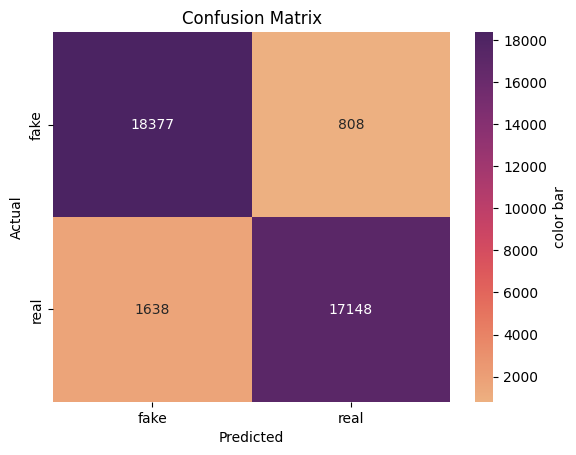

F1 Score :  0.9355148628772721


In [23]:
# Calculate the confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(act_labels, pred_labels)
# Plot confusion matrix heat map
sns.heatmap(conf_mat, cmap="flare",annot=True, fmt = "g", 
            cbar_kws={"label":"color bar"},
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrix_BiLSTM.png")
plt.show()
from sklearn.metrics import f1_score
f1_score = f1_score(pred_labels, act_labels, average='macro')
print('F1 Score : ', f1_score)

In [24]:
import numpy as np
import sklearn.metrics

"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

eer = compute_eer(act_labels, pred_labels)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.065
